# Controllable Face Generation via Conditional ALAE

In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
import imageio

import torch
from albumentations import HorizontalFlip, Compose, KeypointParams
from albumentations.pytorch import ToTensor
from torchvision.utils import make_grid

import utils
from rotation import FaceRotationModel

### 1 Model

In [2]:
ON_GPU=False

In [4]:
cfg = utils.build_configuration(configs_dir='../configs/')
cfg.merge_from_file('../configs/rotation.yaml')

model = FaceRotationModel(
    landmarks_dim=cfg.MODEL.LANDMARKS_DIM,
    rotation_num_layers=cfg.MODEL.ROTATION_NUM_LAYERS,
    critic_num_layers=cfg.MODEL.CRITIC_NUM_LAYERS,
    face_alignment_device='cpu' if not ON_GPU else 'cuda',
    startf=cfg.MODEL.START_CHANNEL_COUNT,
    layer_count=cfg.MODEL.LAYER_COUNT,
    maxf=cfg.MODEL.MAX_CHANNEL_COUNT,
    latent_size=cfg.MODEL.LATENT_SPACE_SIZE,
    truncation_psi=cfg.MODEL.TRUNCATIOM_PSI,
    truncation_cutoff=cfg.MODEL.TRUNCATIOM_CUTOFF,
    mapping_layers=cfg.MODEL.MAPPING_LAYERS,
    channels=cfg.MODEL.CHANNELS,
    generator=cfg.MODEL.GENERATOR,
    encoder=cfg.MODEL.ENCODER
)
model.load_state_dict(torch.load('../checkpts/face_rotation_model.pt', map_location='cpu'))
model = model.to_cuda() if ON_GPU else model.cpu()
model = model.eval()

### 2 Data
There is a batch from the demo to test on, but if you want, you can try inference on another data from our parsed VoxCeleb dataset.

In [5]:
INITIALIZE_DATASET=False

In [6]:
if INITIALIZE_DATASET:
    from data.dataset import SingleFaceDataset, BatchCollate
    
    transform = Compose([HorizontalFlip(), ToTensor()], keypoint_params=KeypointParams(format='xy'))
    transform_ci = Compose([ToTensor()], keypoint_params=KeypointParams(format='xy'))
    dataset = SingleFaceDataset(
        root='../../dataset/id00061',
        center_identity_size=16,
        center_identity_step=32,
        transform=transform,
        transform_ci=transform_ci,
        size=800
    )
    batch_collate = BatchCollate()
    dataloader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=8,
        shuffle=True,
        collate_fn=batch_collate,
        drop_last=True
    )
else:
    batch = torch.load('demo_batch.pt')

In [7]:
if INITIALIZE_DATASET:
    batch = next(iter(dataloader))
batch = model.parse_batch(batch)

### 3 Facial keypoints image transfer

In [8]:
def denormalize(x):
    return (x + 1) / 2

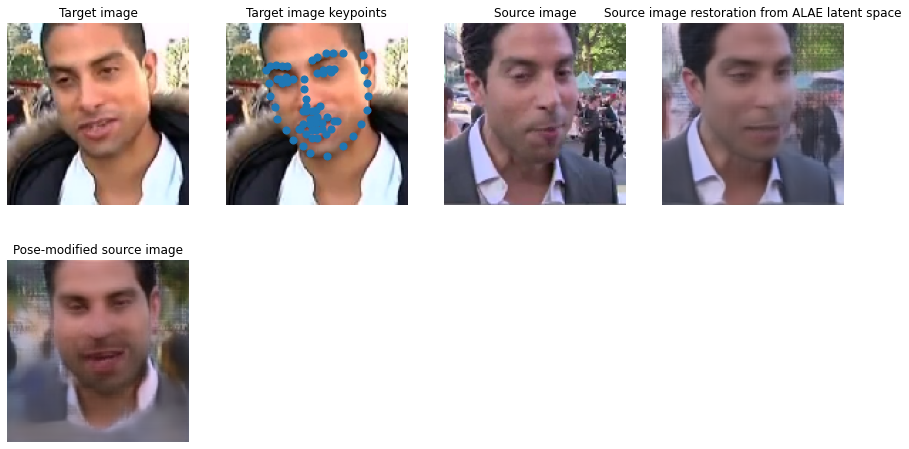

In [9]:
SOURCE_BATCH_IDX=1
source_img = batch['image'][SOURCE_BATCH_IDX]

TARGET_BATCH_IDX=0
target_img = batch['image'][TARGET_BATCH_IDX]
target_keypoints = batch['keypoints'][TARGET_BATCH_IDX]

plt.figure(figsize=(15, 8))

plt.subplot(2, 4, 1)
plt.title('Target image')
plt.imshow(denormalize(target_img).permute(1, 2, 0).cpu())
plt.axis('off')

plt.subplot(2, 4, 2)
plt.title('Target image keypoints')
plt.imshow(denormalize(target_img).permute(1, 2, 0).cpu())
plt.scatter(target_keypoints[:, 0].cpu(), target_keypoints[:, 1].cpu(), s=50)
plt.axis('off')

plt.subplot(2, 4, 3)
plt.title('Source image')
plt.imshow(denormalize(source_img).permute(1, 2, 0).cpu())
plt.axis('off')

plt.subplot(2, 4, 4)
plt.title('Source image restoration from ALAE latent space')
with torch.no_grad():
    z_s = model.encode(source_img[None])
    x_s_restored = model.generate(z_s.unsqueeze(1).repeat(1, 12, 1))
plt.imshow(denormalize(x_s_restored[0]).permute(1, 2, 0).cpu())
plt.axis('off')

plt.subplot(2, 4, 5)
with torch.no_grad():
    x_s_modified = model.inference(source_img[None], target_img[None])
plt.title('Pose-modified source image')
plt.imshow(denormalize(x_s_modified[0]).permute(1, 2, 0).cpu())
plt.axis('off');

### 4 Talking Heads

In [18]:
MAKE_GIF=True

In [27]:
def save_gif(source_img, f_s, target_sequence, f_t, result_sequence, f_r):
    source_img = (denormalize(source_img).cpu().permute(1, 2, 0).numpy() * 255).astype(np.uint8)
    imageio.imsave(f_s, source_img)
    
    target_sequence = (denormalize(target_sequence).cpu().permute(0, 2, 3, 1).numpy() * 255).astype(np.uint8)
    imageio.mimsave(f_t, target_sequence)
    result_sequence = (denormalize(result_sequence).cpu().permute(0, 2, 3, 1).numpy() * 255).astype(np.uint8)
    imageio.mimsave(f_r, result_sequence)

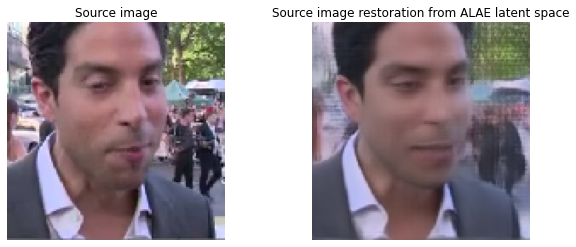

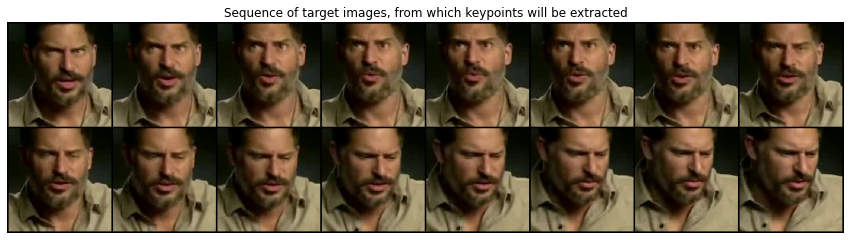

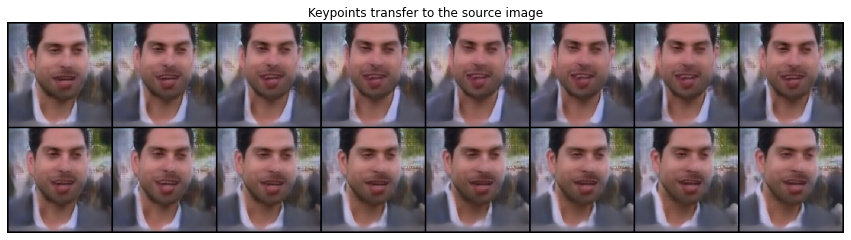

In [12]:
SOURCE_BATCH_IDX=1
source_img = batch['image'][SOURCE_BATCH_IDX]

TARGET_SEQUENCE_BATCH_IDX=3
target_sequence = batch['ci'][TARGET_SEQUENCE_BATCH_IDX]

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title('Source image')
plt.imshow(denormalize(source_img).permute(1, 2, 0))
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('Source image restoration from ALAE latent space')
with torch.no_grad():
    z_s = model.encode(source_img[None])
    x_s_restored = model.generate(z_s.unsqueeze(1).repeat(1, 12, 1))
plt.imshow(denormalize(x_s_restored[0]).permute(1, 2, 0).cpu())
plt.axis('off')

plt.figure(figsize=(15, 8))
plt.title('Sequence of target images, from which keypoints will be extracted')
plt.imshow(make_grid(denormalize(target_sequence).cpu()).permute(1, 2, 0))
plt.axis('off')

plt.figure(figsize=(15, 8))
plt.title('Keypoints transfer to the source image')
with torch.no_grad():
    target_sequence_keypoints = model.get_keypoints_from_batch(target_sequence)
    x_s_modified = model.rotate_face_from_z(
        z=z_s.repeat(target_sequence_keypoints.shape[0], 1),
        c=target_sequence_keypoints
    )
plt.imshow(make_grid(denormalize(x_s_modified).cpu()).permute(1, 2, 0))
plt.axis('off');

In [28]:
if MAKE_GIF:
    save_gif(
        source_img, '../demo/custom_source.PNG',
        target_sequence, '../demo/custom_targets.gif',
        x_s_modified, '../demo/custom_results.gif'
    )